# Gather required libraries

In [1]:
import scipy
from scipy.integrate import odeint
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 
import pandas as pd

# Test data

In [2]:
data = pd.read_csv("5. decay_rate_1 T19T + U19G CY5_resuls.csv", comment='#',sep=',') #T19T + U19G CY5
data

,Time_Points,Substrate,Product_1,Product_2
0,0,1.000,0.000,0.000
1,10,0.440,0.024,0.054
2,30,0.216,0.099,0.168
3,60,0.164,0.105,0.201
4,180,0.111,0.123,0.240
5,360,0.079,0.117,0.249
6,1800,0.056,0.216,0.161
7,6000,0.000,0.155,0.224


In [3]:
substrate_data_norm = []
product_data1_norm = []
product_data2_norm = []

for i in range(0,8):
    # Take column of the data frame
    d1 = data["Substrate"]
    d2 = data["Product_1"]
    d3 = data["Product_2"]
    
    # Sum the total ammounf in each row
    d_total = d1[i]+d2[i]+d3[i]
    
    # Normalize the substrate
    sub_norm = d1[i]/d_total
    sub_norm = round(sub_norm, 3)
    substrate_data_norm.append(sub_norm)
    
    #Normalize the product 1
    prod1_norm = d2[i]/d_total
    prod1_norm = round(prod1_norm, 3)
    product_data1_norm.append(prod1_norm)
    
    #Normalize the product 1
    prod2_norm = d3[i]/d_total
    prod2_norm = round(prod2_norm, 3)
    product_data2_norm.append(prod2_norm)

data["Substrate_norm"] = substrate_data_norm
data["Product_1_norm"] = product_data1_norm
data["Product_2_norm"] = product_data2_norm
data

,Time_Points,Substrate,Product_1,Product_2,Substrate_norm,Product_1_norm,Product_2_norm
0,0,1.000,0.000,0.000,1.000,0.000,0.000
1,10,0.440,0.024,0.054,0.849,0.046,0.104
2,30,0.216,0.099,0.168,0.447,0.205,0.348
3,60,0.164,0.105,0.201,0.349,0.223,0.428
4,180,0.111,0.123,0.240,0.234,0.259,0.506
5,360,0.079,0.117,0.249,0.178,0.263,0.560
6,1800,0.056,0.216,0.161,0.129,0.499,0.372
7,6000,0.000,0.155,0.224,0.000,0.409,0.591


In [4]:
# Given data (time and substrate concentration)

time_data = np.array(data["Time_Points"])  # Time points
substrate_data = np.array(data["Substrate_norm"])  # Substrate concentration over time
product_data1 = np.array(data["Product_1_norm"])  # Concentration of product 1 over time
product_data2 = np.array(data["Product_2_norm"])  # Concentration of product 2 over time
product_data3 = [0] * len(time_data)  # No product 3

# Define functions

In [5]:
# Define the coupled ODE system for substrate depletion and product formation
def ode_system(t, y, k_formation1, k_formation2, k_formation3, k_trimming12, k_trimming23, k_trimming13):
    S, P1, P2, P3 = y

    # Update rates for the absence of product 3
    if P3 == 0:
        k_formation3 = 0
        k_trimming23 = 0
        k_trimming13 = 0

    dSdt = -k_formation1 * S - k_formation2 * S - k_formation3 * S
    dP1dt = k_formation1 * S - k_trimming12 * P1 - k_trimming13 * P1
    dP2dt = k_formation2 * S + k_trimming12 * P1 - k_trimming23 * P2
    dP3dt = k_formation3 * S - k_trimming13 * P3

    return [dSdt, dP1dt, dP2dt, dP3dt]

#-------------------------------------------------------------------------------------------------------------------------------

# Define the fitting function for least squares minimization
def fitting_function(params):
    k_formation1, k_formation2, k_formation3, k_trimming12, k_trimming23, k_trimming13 = params
    sol = solve_ivp(
        lambda t, y: ode_system(t, y, k_formation1, k_formation2, k_formation3, k_trimming12, k_trimming23, k_trimming13),
        [time_data[0], time_data[-1]],
        [substrate_data[0], product_data1[0], product_data2[0], product_data3[0]],
        t_eval=time_data,
        method='LSODA'
    )
    y_predicted = sol.y
    residuals_substrate = y_predicted[0] - substrate_data
    residuals_product1 = y_predicted[1] - product_data1
    residuals_product2 = y_predicted[2] - product_data2
    residuals_product3 = y_predicted[3] - product_data3
    return np.concatenate((residuals_substrate, residuals_product1, residuals_product2, residuals_product3))

#-------------------------------------------------------------------------------------------------------------------------------

# Evalutation of the quality of the fit:

# Function to calculate R-squared
def r_squared(y_true, y_pred):
    mean_y = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y)**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    return 1 - (ss_residual / ss_total)

# Function to calculate Sum of Squared Residuals (SSR)
def sum_squared_residuals(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

# Perform fitting 

In [6]:
# Initial guess for parameters
# k1, k2, k3, k_trim12, k_trim23, k_trim13
initial_guess = [0.1, 0.1, 0, 0.1, 0, 0]  # Example initial guess for the parameters

# Fit the fitting function to the data using least squares
result = least_squares(fitting_function, initial_guess)

# Extract the optimal parameters and set any negative parameter to 0
# For each parameter, the max(0, parameter) function ensures that if the parameter is negative, it is set to zero
k_formation1_opt, k_formation2_opt, k_formation3_opt, k_trimming12_opt, k_trimming23_opt, k_trimming13_opt = result.x
k_formation1_opt = max(0, k_formation1_opt)
k_formation2_opt = max(0, k_formation2_opt)
k_formation3_opt = max(0, k_formation3_opt)
k_trimming12_opt = max(0, k_trimming12_opt)
k_trimming23_opt = max(0, k_trimming23_opt)
k_trimming13_opt = max(0, k_trimming13_opt)

# Plot the fitting 

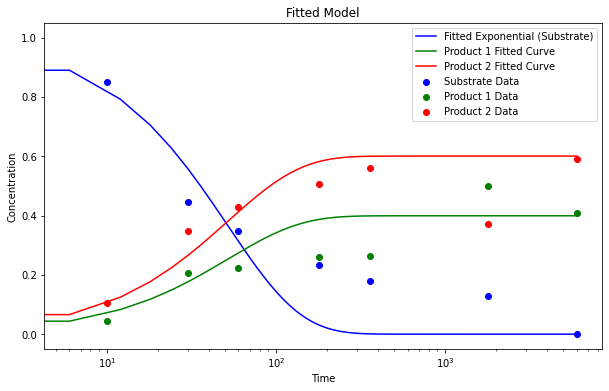

k_formation1: 0.0077333378631455965
k_formation2: 0.011632001629010905
k_formation3: 0
k_trimming12: 0
k_trimming23: 0
k_trimming13: 0


In [7]:
# Define the fitted function
def fitted_system(t, y, k_formation1, k_formation2, k_formation3, k_trimming12, k_trimming23, k_trimming13):
    return ode_system(t, y, k_formation1, k_formation2, k_formation3, k_trimming12, k_trimming23, k_trimming13)

# Time values for plotting
x_values = np.linspace(0, 6000, 1000)

# Initial conditions for solving ODE
initial_conditions = [substrate_data[0], product_data1[0], product_data2[0], product_data3[0]]

# Solve the ODE with optimal parameters
sol = solve_ivp(
    lambda t, y: fitted_system(t, y, k_formation1_opt, k_formation2_opt, k_formation3_opt, k_trimming12_opt, k_trimming23_opt, k_trimming13_opt),
    [x_values[0], x_values[-1]], initial_conditions, t_eval=x_values, method='LSODA'
)

# Extract the fitted curves
substrate_fit = sol.y[0]
product1_fit = sol.y[1]
product2_fit = sol.y[2]
product3_fit = sol.y[3]

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot the original data
plt.scatter(time_data, substrate_data, label='Substrate Data', color='blue')
plt.scatter(time_data, product_data1, label='Product 1 Data', color='green')
plt.scatter(time_data, product_data2, label='Product 2 Data', color='red')
if any(product_data3):  # Plot only if there's actual data for product 3
    plt.scatter(time_data, product_data3, label='Product 3 Data', color='orange')

# Plot the fitted curves
plt.plot(x_values, substrate_fit, 'b-', label='Fitted Exponential (Substrate)')
plt.plot(x_values, product1_fit, 'g-', label='Product 1 Fitted Curve')
plt.plot(x_values, product2_fit, 'r-', label='Product 2 Fitted Curve')
if any(product_data3):  # Plot only if there's actual data for product 3
    plt.plot(x_values, product3_fit, 'orange', label='Product 3 Fitted Curve')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fitted Model')
plt.xscale('log')
plt.legend()
plt.show()

print("k_formation1:", k_formation1_opt)
print("k_formation2:", k_formation2_opt)
print("k_formation3:", k_formation3_opt)
print("k_trimming12:", k_trimming12_opt)
print("k_trimming23:", k_trimming23_opt)
print("k_trimming13:", k_trimming13_opt)

# Determine the quality of the fit 

In [8]:
# Evaluate the quality of the fit
sol_opt = solve_ivp(
    lambda t, y: ode_system(t, y, k_formation1_opt, k_formation2_opt, k_formation3_opt, k_trimming12_opt, k_trimming23_opt, k_trimming13_opt),
    [time_data[0], time_data[-1]], 
    [substrate_data[0], product_data1[0], product_data2[0], product_data3[0]], 
    t_eval=time_data, method='LSODA'
)
y_predicted_opt = sol_opt.y

r2_substrate = r_squared(substrate_data, y_predicted_opt[0])
r2_product1 = r_squared(product_data1, y_predicted_opt[1])
r2_product2 = r_squared(product_data2, y_predicted_opt[2])
r2_product3 = r_squared(product_data3, y_predicted_opt[3])

ssr_substrate = sum_squared_residuals(substrate_data, y_predicted_opt[0])
ssr_product1 = sum_squared_residuals(product_data1, y_predicted_opt[1])
ssr_product2 = sum_squared_residuals(product_data2, y_predicted_opt[2])
ssr_product3 = sum_squared_residuals(product_data3, y_predicted_opt[3])

# Aggregate measures (optional)
r2_average = np.mean([r2_product1, r2_product2, r2_product3])
ssr_total = ssr_product1 + ssr_product2 + ssr_product3

print("\nR-squared values:")
print("Substrate:", r2_substrate)
print("Product 1:", r2_product1)
print("Product 2:", r2_product2)
if any(product_data3):
    print("Product 3:", r2_product3)
    print("Average R-squared:", r2_average)

print("\nSum of Squared Residuals:")
print("Substrate:", ssr_substrate)
print("Product 1:", ssr_product1)
print("Product 2:", ssr_product2)
if any(product_data3):
    print("Product 3:", ssr_product3)
    print("Total SSR:", ssr_total)


R-squared values:
Substrate: 0.881466847280069
Product 1: 0.7464398907750893
Product 2: 0.7870990849074295

Sum of Squared Residuals:
Substrate: 0.10391416266210014
Product 1: 0.04900049110771397
Product 2: 0.06698285929381016


C:\Users\Marius\AppData\Local\Temp/ipykernel_17496/3106383559.py:46: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (ss_residual / ss_total)
